In [42]:
# Importing libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [16]:
# Import parquet file which has clean dates
# First, define data path
current_path = os.getcwd()
parent_dir = os.path.dirname(current_path)
grandparent_dir = os.path.dirname(parent_dir)
data_dir = os.path.join(grandparent_dir, 'data')

# parquet exists in data > financial_disc > intermediate_dfs
parquet_path = os.path.join(data_dir, 'financial_disc', 'intermediate_dfs', 'financial_disc.parquet')
df = pd.read_parquet(parquet_path)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2019751 entries, 0 to 2019750
Data columns (total 50 columns):
 #   Column                               Dtype  
---  ------                               -----  
 0   person_id                            int64  
 1   person_url                           object 
 2   filepath                             object 
 3   disclosure_year                      int64  
 4   notes                                object 
 5   date_created                         object 
 6   date_modified                        object 
 7   type                                 object 
 8   agreement_id                         float64
 9   agree_date_raw                       object 
 10  parties_and_terms                    object 
 11  agree_redacted                       object 
 12  gift_id                              float64
 13  gift_source                          object 
 14  gift_description                     object 
 15  gift_value                      

In [17]:
# We first build our model using a sample of person_ids: we will use top 25 person_ids with max number of dockets
# Import the list of selected authors from dockets > intermediate_dfs
selected_person_ids_path = os.path.join(data_dir, 'dockets', 'intermediate_dfs', 'sampled_judge_ids.csv')
selected_person_ids = pd.read_csv(selected_person_ids_path)
selected_person_ids = selected_person_ids['author_id'].tolist()
print(selected_person_ids)

[2678, 2416, 697, 1330, 1811, 3081, 1072, 568, 3373, 422, 3309, 265, 1805, 2926, 1532, 1105, 1816, 2462, 1574, 1984, 2671, 2490, 1442, 1380, 579]


In [19]:
# Filter the dataframe to include only the selected person_ids
df_sampled = df[df['person_id'].isin(selected_person_ids)]
print(f"Now the dataframe has {df_sampled.shape[0]} rows")
df_sampled.head()

Now the dataframe has 13254 rows


,person_id,person_url,filepath,disclosure_year,notes,date_created,date_modified,type,agreement_id,agree_date_raw,...,reimbursement_id,reimb_source,reimb_location,reimb_purpose,items_paid_or_provided,reimb_redacted,spouse_income_id,sp_inc_source_type,sp_inc_date_raw,sp_inc_redacted
13967,568,https://www.courtlistener.com/api/rest/v4/peop...,https://storage.courtlistener.com/us/federal/j...,2015,None,2021-01-10,2021-01-10,investment,NaN,None,...,NaN,None,None,NaN,None,None,NaN,None,None,None
13968,568,https://www.courtlistener.com/api/rest/v4/peop...,https://storage.courtlistener.com/us/federal/j...,2015,None,2021-01-10,2021-01-10,investment,NaN,None,...,NaN,None,None,NaN,None,None,NaN,None,None,None
13969,568,https://www.courtlistener.com/api/rest/v4/peop...,https://storage.courtlistener.com/us/federal/j...,2015,None,2021-01-10,2021-01-10,non_investment_income,NaN,None,...,NaN,None,None,NaN,None,None,NaN,None,None,None
13970,568,https://www.courtlistener.com/api/rest/v4/peop...,https://storage.courtlistener.com/us/federal/j...,2015,None,2021-01-10,2021-01-10,reimbursement,NaN,None,...,32358.0,American Conterence Institute,"New York, NY",NaN,"transportabon, meals, hotel",False,NaN,None,None,None
13971,568,https://www.courtlistener.com/api/rest/v4/peop...,https://storage.courtlistener.com/us/federal/j...,2015,None,2021-01-10,2021-01-10,reimbursement,NaN,None,...,32359.0,American Conference Institute,"New York, NY",NaN,"transportation, meals, hotel",False,NaN,None,None,None


In [14]:
# Export this for manual inspection
df_sampled.to_csv('sample.csv', index=False)

In [20]:
# Filter the sampled dataframe where the type is 'investment'
df_sampled_investment = df_sampled[df_sampled['type'] == 'investment']
print(f"Now the dataframe has {df_sampled_investment.shape[0]} rows")

# Now defining all columns that are relevant for the investment model
investment_columns = [
    'person_id',
    'disclosure_year',
    'date_created',
    'date_modified',
    'investment_id',
    'inv_description',
    'inv_redacted',
    'income_during_reporting_period_code',
    'income_during_reporting_period_type',
    'gross_value_code',
    'gross_value_method',
    'transaction_during_reporting_period',
    'transaction_date_raw',
    'transaction_date',
    'transaction_value_code',
    'transaction_gain_code',
    'transaction_partner',
    'inv_has_inferred_values'
    ]

# Keep only investment relevant columns as defined above
df_sampled_investment_cols = df_sampled_investment[investment_columns]
df_sampled_investment_cols.info()

Now the dataframe has 12242 rows
<class 'pandas.core.frame.DataFrame'>
Index: 12242 entries, 13967 to 2017964
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   person_id                            12242 non-null  int64  
 1   disclosure_year                      12242 non-null  int64  
 2   date_created                         12242 non-null  object 
 3   date_modified                        12242 non-null  object 
 4   investment_id                        12242 non-null  float64
 5   inv_description                      12188 non-null  object 
 6   inv_redacted                         12242 non-null  object 
 7   income_during_reporting_period_code  5653 non-null   object 
 8   income_during_reporting_period_type  5645 non-null   object 
 9   gross_value_code                     5541 non-null   object 
 10  gross_value_method                   5167 non-null   object 

In [21]:
# Saving this as a csv for manual inspection
# df_sampled_investment_cols.to_csv('sample_investment_only_cols.csv', index=False)

In [22]:
# For analysis, we need to clean it up even more
investment_analysis_columns = [
    'person_id',
    'disclosure_year',
    'investment_id',
    'inv_description']

# Keep only investment relevant columns as defined above
df_sampled_investment_analysis = df_sampled_investment_cols[investment_analysis_columns]
df_sampled_investment_analysis.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12242 entries, 13967 to 2017964
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   person_id        12242 non-null  int64  
 1   disclosure_year  12242 non-null  int64  
 2   investment_id    12242 non-null  float64
 3   inv_description  12188 non-null  object 
dtypes: float64(1), int64(2), object(1)
memory usage: 478.2+ KB


In [24]:
# Importing dockets data
sampled_dockets_path = os.path.join(data_dir, 'dockets', 'intermediate_dfs', 'sampled_judges.parquet')
sampled_dockets = pd.read_parquet(sampled_dockets_path)
sampled_dockets.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5913 entries, 3550 to 191591
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   absolute_url                 5913 non-null   object 
 1   attorney                     5755 non-null   object 
 2   caseName                     5913 non-null   object 
 3   caseNameFull                 5811 non-null   object 
 4   citation                     5913 non-null   object 
 5   citeCount                    5913 non-null   int64  
 6   cluster_id                   5913 non-null   int64  
 7   court                        5913 non-null   object 
 8   court_citation_string        5913 non-null   object 
 9   court_id                     5913 non-null   object 
 10  dateArgued                   0 non-null      object 
 11  dateFiled                    5913 non-null   object 
 12  dateReargued                 0 non-null      float64
 13  dateReargumentDeni

In [26]:
# Define the columns that are relevant for analysis
dockets_analysis_columns = [
   'author_id',
   'judge',
   'docketNumber',
   'docket_id',
   'snippet',
   'caseName',
   'dateFiled'
]

# Keep only dockets relevant columns as defined above
sampled_dockets_analysis = sampled_dockets[dockets_analysis_columns]
sampled_dockets_analysis.head()

,author_id,judge,docketNumber,docket_id,snippet,caseName,dateFiled
3550,2490,Paine,91-6548-CIV.,691131,\n795 F.Supp. 1112 (1992)\nChristina Elisabeth...,Watchorn Ex Rel. Christenson v. Town of Davie,1992-08-07
3551,2490,Paine,"93-2123-CIV-PAINE, 94-1692-CIV-PAINE",2379325,"\n127 F.Supp.2d 1239 (1999)\nDICTIOMATIC, INC....","Dictiomatic, Inc. v. United States Fidelity & ...",1999-06-15
3552,2490,Paine,99-10054-CIV,2371116,\n104 F.Supp.2d 1368 (2000)\nElizabeth J. NEUM...,Neumont v. Monroe County Florida,2000-06-21
3553,2490,Paine,98-10060-CIV.,2369251,"\n42 F.Supp.2d 1344 (1999)\nDeborah K. BRANDT,...","Brandt v. Weather Channel, Inc.",1999-03-18
3554,2490,Paine,99-10054-CIV-PAINE/VITUNAC,2368734,\n280 F.Supp.2d 1367 (2003)\nElizabeth J. NEUM...,"Neumont v. Monroe County, Florida",2003-05-21


In [27]:
# Separate party-1 and party-2 from caseName in the format party-1 v. party-2
sampled_dockets_analysis['party_1'] = sampled_dockets_analysis['caseName'].str.split(' v. ').str[0]
sampled_dockets_analysis['party_2'] = sampled_dockets_analysis['caseName'].str.split(' v. ').str[1]
sampled_dockets_analysis.head()

/var/folders/54/mhs5zkcs6zb1_y58hd7pczjc0000gn/T/ipykernel_73915/37782030.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sampled_dockets_analysis['party_1'] = sampled_dockets_analysis['caseName'].str.split(' v. ').str[0]
/var/folders/54/mhs5zkcs6zb1_y58hd7pczjc0000gn/T/ipykernel_73915/37782030.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sampled_dockets_analysis['party_2'] = sampled_dockets_analysis['caseName'].str.split(' v. ').str[1]


,author_id,judge,docketNumber,docket_id,snippet,caseName,dateFiled,party_1,party_2
3550,2490,Paine,91-6548-CIV.,691131,\n795 F.Supp. 1112 (1992)\nChristina Elisabeth...,Watchorn Ex Rel. Christenson v. Town of Davie,1992-08-07,Watchorn Ex Rel. Christenson,Town of Davie
3551,2490,Paine,"93-2123-CIV-PAINE, 94-1692-CIV-PAINE",2379325,"\n127 F.Supp.2d 1239 (1999)\nDICTIOMATIC, INC....","Dictiomatic, Inc. v. United States Fidelity & ...",1999-06-15,"Dictiomatic, Inc.",United States Fidelity & Guaranty Co.
3552,2490,Paine,99-10054-CIV,2371116,\n104 F.Supp.2d 1368 (2000)\nElizabeth J. NEUM...,Neumont v. Monroe County Florida,2000-06-21,Neumont,Monroe County Florida
3553,2490,Paine,98-10060-CIV.,2369251,"\n42 F.Supp.2d 1344 (1999)\nDeborah K. BRANDT,...","Brandt v. Weather Channel, Inc.",1999-03-18,Brandt,"Weather Channel, Inc."
3554,2490,Paine,99-10054-CIV-PAINE/VITUNAC,2368734,\n280 F.Supp.2d 1367 (2003)\nElizabeth J. NEUM...,"Neumont v. Monroe County, Florida",2003-05-21,Neumont,"Monroe County, Florida"


In [28]:
sampled_dockets_analysis.to_csv('sampled_dockets_analysis.csv', index=False)

In [29]:
# Convert the dateFiled to datetime
sampled_dockets_analysis['dateFiled'] = pd.to_datetime(sampled_dockets_analysis['dateFiled'], errors='coerce')

# Extract the year from this date
sampled_dockets_analysis['dateFiled_year'] = sampled_dockets_analysis['dateFiled'].dt.year
sampled_dockets_analysis.head()

/var/folders/54/mhs5zkcs6zb1_y58hd7pczjc0000gn/T/ipykernel_73915/4131001170.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sampled_dockets_analysis['dateFiled'] = pd.to_datetime(sampled_dockets_analysis['dateFiled'], errors='coerce')
/var/folders/54/mhs5zkcs6zb1_y58hd7pczjc0000gn/T/ipykernel_73915/4131001170.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sampled_dockets_analysis['dateFiled_year'] = sampled_dockets_analysis['dateFiled'].dt.year


,author_id,judge,docketNumber,docket_id,snippet,caseName,dateFiled,party_1,party_2,dateFiled_year
3550,2490,Paine,91-6548-CIV.,691131,\n795 F.Supp. 1112 (1992)\nChristina Elisabeth...,Watchorn Ex Rel. Christenson v. Town of Davie,1992-08-07,Watchorn Ex Rel. Christenson,Town of Davie,1992
3551,2490,Paine,"93-2123-CIV-PAINE, 94-1692-CIV-PAINE",2379325,"\n127 F.Supp.2d 1239 (1999)\nDICTIOMATIC, INC....","Dictiomatic, Inc. v. United States Fidelity & ...",1999-06-15,"Dictiomatic, Inc.",United States Fidelity & Guaranty Co.,1999
3552,2490,Paine,99-10054-CIV,2371116,\n104 F.Supp.2d 1368 (2000)\nElizabeth J. NEUM...,Neumont v. Monroe County Florida,2000-06-21,Neumont,Monroe County Florida,2000
3553,2490,Paine,98-10060-CIV.,2369251,"\n42 F.Supp.2d 1344 (1999)\nDeborah K. BRANDT,...","Brandt v. Weather Channel, Inc.",1999-03-18,Brandt,"Weather Channel, Inc.",1999
3554,2490,Paine,99-10054-CIV-PAINE/VITUNAC,2368734,\n280 F.Supp.2d 1367 (2003)\nElizabeth J. NEUM...,"Neumont v. Monroe County, Florida",2003-05-21,Neumont,"Monroe County, Florida",2003


In [30]:
# Aggregating docket count by year 
docket_count_by_year = sampled_dockets_analysis.groupby('dateFiled_year').size().reset_index(name='docket_count')
docket_count_by_year.head()

,dateFiled_year,docket_count
0,1957,2
1,1978,17
2,1979,18
3,1980,41
4,1981,49


In [31]:
# Similarly, we can aggregate the investment count by year
investment_count_by_year = df_sampled_investment_analysis.groupby('disclosure_year').size().reset_index(name='investment_count')
investment_count_by_year.head()

,disclosure_year,investment_count
0,2003,457
1,2004,396
2,2005,1340
3,2006,785
4,2007,1745


In [41]:
# Now we can merge these two dataframes on year
merged_df = pd.merge(docket_count_by_year, investment_count_by_year, left_on='dateFiled_year', right_on='disclosure_year', how='outer')

# Transfors for the merged dataframe
# All columns are float, so we convert them to int
for column in merged_df.columns:
    merged_df[column] = merged_df[column].fillna(0).astype(int)

# Replace zero values in 'dateFiled_year' with the corresponding values from 'disclosure_year'
merged_df['year'] = merged_df['dateFiled_year'].mask(merged_df['dateFiled_year'] == 0, merged_df['disclosure_year']).astype(int)

# Examine dataframe
merged_df.tail()

,dateFiled_year,docket_count,disclosure_year,investment_count,year
39,0,0,2016,534,2016
40,0,0,2017,353,2017
41,0,0,2018,439,2018
42,0,0,2019,477,2019
43,0,0,2020,414,2020


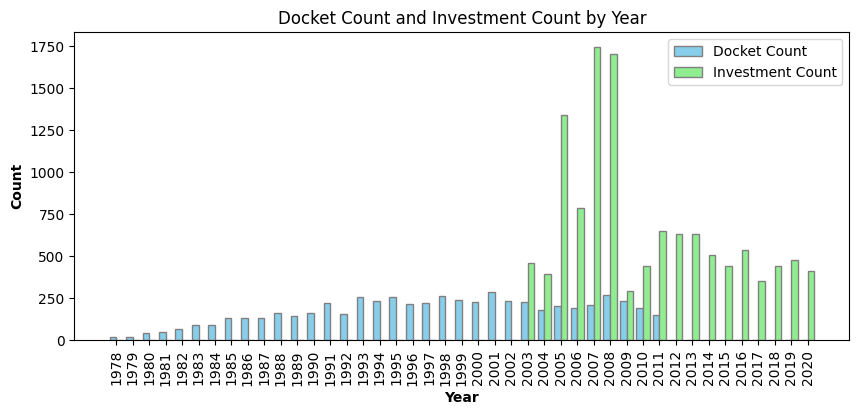

In [53]:
# Set up the figure and axis
plt.figure(figsize=(10,4))

# Define the width of each bar
bar_width = 0.4

# Define the positions for the bars on the X-axis
# Filter for years after 1975
merged_df = merged_df[merged_df['year'] > 1975]
r1 = merged_df['year']  # Original positions for the first set of bars
r2 = [x + bar_width for x in r1]  # Positions for the second set of bars, shifted to the right

# Plotting the bars
plt.bar(r1, merged_df['docket_count'], color='skyblue', width=bar_width, edgecolor='grey', label='Docket Count')
plt.bar(r2, merged_df['investment_count'], color='lightgreen', width=bar_width, edgecolor='grey', label='Investment Count')

# Add labels and title
plt.xlabel('Year', fontweight='bold')
plt.ylabel('Count', fontweight='bold')
plt.title('Docket Count and Investment Count by Year')
plt.xticks([r + bar_width/2 for r in r1], merged_df['year'], rotation=90)  # Position X-axis labels to be between bars
plt.legend()

# Show the plot
plt.show()

In [55]:
# Save dataframes for further analysis
sample_data_dir = os.path.join(data_dir, 'conflict', 'sample')

# Save the sampled dockets and investment dataframes
sampled_dockets_analysis.to_csv(os.path.join(sample_data_dir, 'sampled_dockets.csv'), index=False)
df_sampled_investment_analysis.to_csv(os.path.join(sample_data_dir, 'sampled_investments.csv'), index=False)